In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import re
import io
import matplotlib.pylab as plt
from fa2 import ForceAtlas2
import json
import ast
from collections import Counter
import pickle

In [7]:
g = nx.read_gpickle("directors_network.gpickle")

In [8]:
g.number_of_nodes()

2050

In [9]:
g.number_of_edges()

87674

In [10]:
degrees = g.degree()
list_degrees = sorted(degrees, key=lambda x: x[1], reverse=True)

In [11]:
print('Director who has actors in common with most directors',list_degrees[0][0])
print('Has actors in common with ' + str(list_degrees[0][1]) + ' different directors')

Actor who has co-acted with most actors: Steven Spielberg
Has acted with 901 different actors


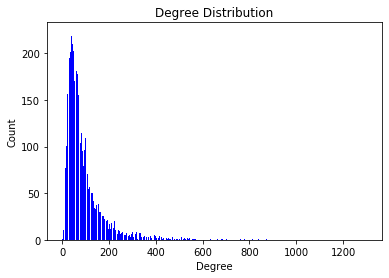

In [22]:
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

In [12]:
gc= max(nx.connected_component_subgraphs(g), key=len)
gc

In [13]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

In [14]:
# Takes a few minutes to run
positions = forceatlas2.forceatlas2_networkx_layout(gc, pos=None, iterations=5000)

100%|██████████| 5000/5000 [05:52<00:00, 14.20it/s]


BarnesHut Approximation  took  27.83  seconds
Repulsion forces  took  311.38  seconds
Gravitational forces  took  0.58  seconds
Attraction forces  took  5.67  seconds
AdjustSpeedAndApplyForces step  took  3.01  seconds


C:\Users\pauli\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


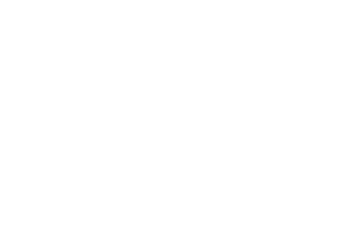

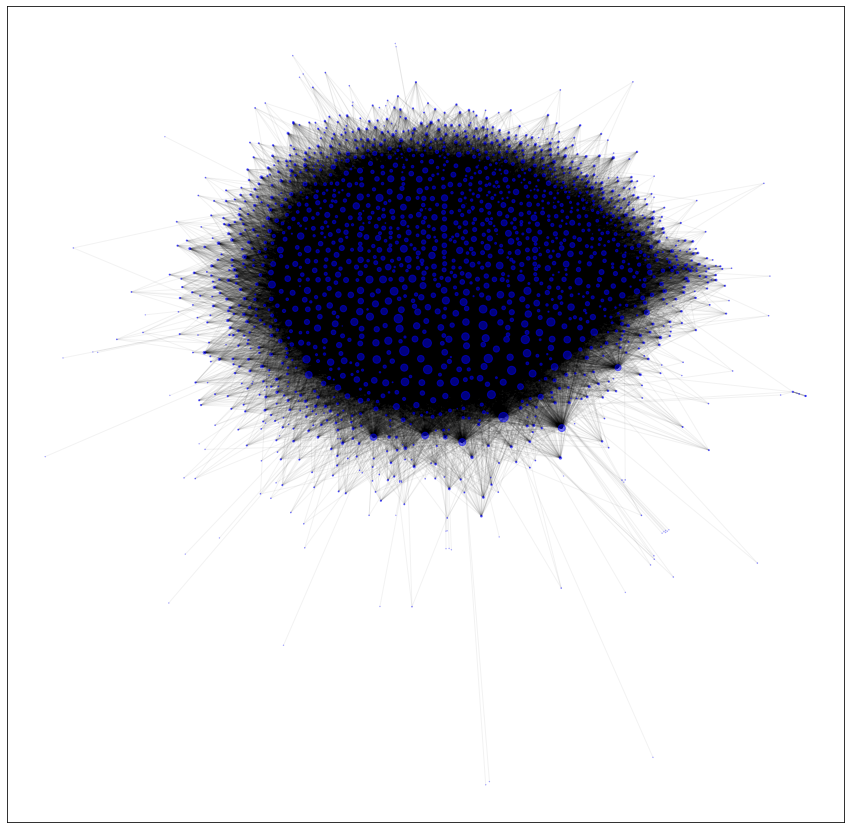

In [15]:
d = dict(gc.degree)
degrees = [(d[node])/10 for node in gc.nodes()]
plt.axis('off')
plt.figure(figsize=(15,15)) 
nx.draw_networkx_nodes(gc, positions ,node_color='blue', node_size= degrees, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(gc, positions, alpha=0.05)
plt.show()